In [1]:
import h5py
import numpy as np
import os
import pandas as pd
import subprocess
import time

from os import listdir
from os.path import isfile, join

import bacco
import baccoemu

import matplotlib
from matplotlib import pyplot as plt

2023-12-29 15:03:52.061517: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-29 15:03:54.235081: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-29 15:03:54.235217: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-29 15:03:54.493360: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-29 15:03:55.163412: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-29 15:03:55.165853: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 20

#matplotlib.rc('text', usetex=True)

## Bacco setup

In [3]:
##### DEFINE QUIJOTE COSMOLOGY ############
# The cosmology is not really needed but
# bacco P(k) corrects some modes according
# to their cosmology, so better have it
# just in case

a_Quijote = 1
Ob = 0.049
Om = 0.3175
hubble = 0.6711
ns = 0.9624
sigma8 = 0.834
cosmopars = dict(
        omega_cdm=Om-Ob,
        omega_baryon=Ob, 
        hubble=hubble, 
        ns=ns, 
        sigma8=sigma8,
        #tau=0.0561,
        A_s=None,
        neutrino_mass=0.,
        w0=-1,
        wa=0,
        tag="cosmo_BOSS"
    )
    
    
cosmo_Quijote = bacco.Cosmology(**cosmopars)
cosmo_Quijote.set_expfactor(a_Quijote)

2023-12-29 15:05:44,787 bacco.cosmo :    initialization took 0.000 secs


In [4]:
ngrid = 256 #1024 #512 #256 #128 #256 #1400
#nmean=0.01 not used
BoxSize=100/hubble
print(BoxSize)

bacco.configuration.update({'pknbody' : {'ngrid'  :  ngrid}})
bacco.configuration.update({'pknbody' : {'log_binning' : True}})
bacco.configuration.update({'pknbody' : {'log_binning_kmax' : 0.99506136}})#
bacco.configuration.update({'pknbody' : {'log_binning_nbins' : 100}})
bacco.configuration.update({'pknbody' : {'min_k' : 0.01721049}})
bacco.configuration.update({'pk' : {'maxk' : 0.99506136}}) 
bacco.configuration.update({'pknbody' : {'interlacing' : True}})

bacco.configuration.update({'pknbody' : {'depmethod' : 'cic'}})

bacco.configuration.update({'nonlinear' : {'concentration' : 'ludlow16'}})

bacco.configuration.update({'number_of_threads' : 12})
bacco.configuration.update({'scaling' : {'disp_ngrid' : ngrid}})

bacco.configuration.update({'pk':{'boltzmann_solver': 'CLASS'}})

149.0090895544628


## Load SAM data from hdf5 files

In [5]:
redshift = 0
dir_dat = '/lscratch/kstoreyf/CAMELS-SAM_data'

In [7]:
fns_dat = [join(dir_dat, f) for f in listdir(dir_dat) if isfile(join(dir_dat, f))]
#idx_sam = 0
#fns_dat = [f'{dir_dat}/LH_{idx_sam}_galprops_z{redshift}.hdf5']

In [14]:
n_sams = len(fns_dat)

## Load PROVABGS data

Downloaded from https://zenodo.org/records/8018936

In [8]:
# probabilistic SMFs
fn_psmf_bgs_q = '../data/data_provabgs/psmf.sv3.bgs_bright_q.z0.01_0.05.dat'
ms, psmf_bgs_q_mean, psmf_bgs_q_std = np.loadtxt(fn_psmf_bgs_q, unpack=True)

fn_psmf_bgs_sf = '../data/data_provabgs/psmf.sv3.bgs_bright_sf.z0.01_0.05.dat'
ms, psmf_bgs_sf_mean, psmf_bgs_sf_std = np.loadtxt(fn_psmf_bgs_sf, unpack=True)

In [19]:
# combine sf and q (star-forming and quiescent)
psmf_bgs_mean = psmf_bgs_sf_mean + psmf_bgs_q_mean
psmf_bgs_std = np.sqrt(psmf_bgs_sf_std**2 + psmf_bgs_q_std**2)

In [20]:
# standard (non-probabilistic) SMF, as check
fn_smf_bgs = '../data/data_provabgs/smf.standard.sv3.bgs_bright.z0.01_0.05.dat'
ms_smf, smf_bgs = np.loadtxt(fn_smf_bgs, unpack=True)

## Plot CAMELS SMFs

In [10]:
log_mass_shift = 9
h = 0.6711 # from perez et al
print(h**3)
vol_Mpc = (100/h)**3 # 100 Mpc/h = 100/h Mpc
vol_hMpc = 100**3 # units Mpc/h!! to match bgs; diff than plotted in camels paper
print(vol_Mpc, vol_hMpc)

0.302246803431
3308554.428527777 1000000


In [11]:
edges = np.linspace(8, 12.5, 40)

bin_width = edges[1] - edges[0]                
bins_avg = edges[0:-1] + bin_width/2.           

In [17]:
smf_arr = []
for i in range(n_sams):
    fn_dat = fns_dat[i]
    with h5py.File(fn_dat, 'r') as f:
        mstar_raw = np.array(f['mstar'])
        log_mstar = np.log10(mstar_raw) + log_mass_shift
        
        phi, edges = np.histogram(log_mstar, bins=edges)   
        smf = phi / vol_Mpc / bin_width
        smf_arr.append(smf)    

/tmp/ipykernel_54507/1712186730.py:6: RuntimeWarning: divide by zero encountered in log10
  log_mstar = np.log10(mstar_raw) + log_mass_shift


In [13]:
def get_distance_sigma(x1, y1, yerr1, x2, y2, xrange):
    xmin, xmax = xrange

    y1 = y1[(x1>=xmin) & (x1<xmax)]
    yerr1 = yerr1[(x1>=xmin) & (x1<xmax)]
    y2 = y2[(x2>=xmin) & (x2<xmax)]

    x1 = x1[(x1>=xmin) & (x1<xmax)]
    x2 = x2[(x2>=xmin) & (x2<xmax)]
    
    # interpolate y2 to be at the same x-vals as x2/y2
    y2_interp = np.interp(x1, x2, y2)
    sigmas = (y2_interp - y1)/yerr1
    sigma_mean = np.mean(np.abs(sigmas))
    return sigma_mean

In [21]:
sigma_means = []
xrange = [8,11]
for i in range(n_sams):
    
    sigma_mean = get_distance_sigma(ms, psmf_bgs_mean, psmf_bgs_std, bins_avg, smf_arr[i], xrange)
    sigma_means.append(sigma_mean)
sigma_means = np.array(sigma_means)

In [37]:
locs_norm = matplotlib.colors.Normalize(np.min(sigma_means), np.max(sigma_means), len(sigma_means))
cmap = matplotlib.cm.get_cmap('cool')
colors = cmap(locs_norm(sigma_means))

/tmp/ipykernel_54507/3813704076.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('cool')


(8.0, 12.5)

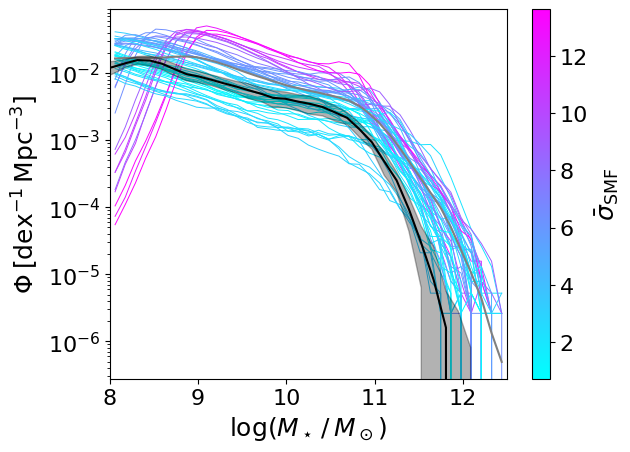

In [40]:
for i in range(n_sams):
    plt.plot(bins_avg, smf_arr[i], lw=0.7, color=colors[i])
ax = plt.gca()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=locs_norm)
plt.colorbar(sm, ax=ax, label=r'$\bar{\sigma}_\text{SMF}$')

smf_mean = np.mean(smf_arr, axis=0)
smf_std = np.std(smf_arr, axis=0)
plt.plot(bins_avg, smf_mean, color='grey')
# plt.fill_between(bins_avg, 
#                  (smf_mean-smf_std), 
#                  (smf_mean+smf_std),
#                  color='magenta', alpha=0.3, lw=2,
#                  label='pSMF all')
    
plt.plot(ms, psmf_bgs_mean, color='black')
plt.fill_between(ms, 
                 psmf_bgs_mean-psmf_bgs_std, 
                 psmf_bgs_mean+psmf_bgs_std,
                 color='black', alpha=0.3,
                 zorder=10000,
                 label='BGS pSMF')
    
plt.yscale('log')
plt.xlabel(r'$\log(M_\star\,/\,M_\odot)$')
plt.ylabel(r'$\Phi \: [\mathrm{dex}^{-1}\, \mathrm{Mpc}^{-3}]$')
plt.xlim(8, 12.5)

## Set up bacco P(k) code

In [41]:
args_power = {'ngrid':ngrid,
                  'box':BoxSize,
                  'cosmology':cosmo_Quijote,
                  'interlacing':True,
                  'kmin':0.1,
                  'kmax':1.0,
                  'nbins':30,
                  'correct_grid':True,
                  'log_binning':False,
                  'deposit_method':'cic',
                  'compute_correlation':False,
                  'zspace':False,
                  'normalise_grid': True,
                  'compute_power2d':False}

In [42]:
import logging
logger = logging.getLogger("bacco.power")
# only log really bad events
logger.setLevel(logging.ERROR)

In [ ]:
pks = []
for i in range(n_sams):
    fn_dat = fns_dat[i]
    with h5py.File(fn_dat, 'r') as f:
        x_arr, y_arr, z_arr = f['x_position'], f['y_position'], f['z_position']
        pos_arr = np.array([x_arr, y_arr, z_arr]).T
        pk = bacco.statistics.compute_powerspectrum(pos=pos_arr, **args_power)
        pks.append(pk)

2023-12-29 15:30:14,560 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2023-12-29 15:30:14,562 bacco.statistics :  setting the grid 256 True
2023-12-29 15:30:14,562 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2023-12-29 15:30:14,564 bacco.statistics : starting deposit 1
2023-12-29 15:30:14,636 bacco.statistics :  mesh done in 0.0739 s
2023-12-29 15:30:14,638 bacco.statistics :  Starting the power spectrum calculation


actor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 188395 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 0; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 188395 (grid1) 188395 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.086896 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.114499 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000152 secs
bacco.power : Deallocating arrays
bacco.mesh : boxsize=149.009094 ngrid=256, nthreads=12, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 178582 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxs

2023-12-29 15:30:14,948 bacco.statistics :  done compute.power
2023-12-29 15:30:14,949 bacco.statistics :  power done in 0.389 s
2023-12-29 15:30:14,980 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2023-12-29 15:30:14,981 bacco.statistics :  setting the grid 256 True
2023-12-29 15:30:14,982 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2023-12-29 15:30:14,983 bacco.statistics : starting deposit 1
2023-12-29 15:30:15,060 bacco.statistics :  mesh done in 0.0783 s
2023-12-29 15:30:15,061 bacco.statistics :  Starting the power spectrum calculation
2023-12-29 15:30:15,353 bacco.statistics :  done compute.power
2023-12-29 15:30:15,354 bacco.statistics :  power done in 0.374 s
2023-12-29 15:30:15,382 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2023-12-29 15:30:15,384 bacco.statistics :  setting the grid 256 True
2023-12-29 15:30:15,384 bacco.statistics : Computing cic mesh with ngrid=256

h : allocating 128.0 Mb
bacco.mesh : binning of 167652 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 0; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 167652 (grid1) 167652 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.081483 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.105470 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.022272 secs
bacco.power : Deallocating arrays
bacco.mesh : boxsize=149.009094 ngrid=256, nthreads=12, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 171268 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposi

2023-12-29 15:30:17,099 bacco.statistics :  done compute.power
2023-12-29 15:30:17,100 bacco.statistics :  power done in 0.377 s
2023-12-29 15:30:17,128 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2023-12-29 15:30:17,129 bacco.statistics :  setting the grid 256 True
2023-12-29 15:30:17,130 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2023-12-29 15:30:17,131 bacco.statistics : starting deposit 1
2023-12-29 15:30:17,202 bacco.statistics :  mesh done in 0.0724 s
2023-12-29 15:30:17,203 bacco.statistics :  Starting the power spectrum calculation
2023-12-29 15:30:17,479 bacco.statistics :  done compute.power
2023-12-29 15:30:17,479 bacco.statistics :  power done in 0.352 s
2023-12-29 15:30:17,504 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2023-12-29 15:30:17,506 bacco.statistics :  setting the grid 256 True
2023-12-29 15:30:17,506 bacco.statistics : Computing cic mesh with ngrid=256

les (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 0; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 188395 (grid1) 188395 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.075569 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.124851 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000177 secs
bacco.power : Deallocating arrays
bacco.mesh : boxsize=149.009094 ngrid=256, nthreads=12, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 178582 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 0; type 0; precision=single; correct_

2023-12-29 15:30:19,478 bacco.statistics :  done compute.power
2023-12-29 15:30:19,479 bacco.statistics :  power done in 0.388 s
2023-12-29 15:30:19,517 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2023-12-29 15:30:19,518 bacco.statistics :  setting the grid 256 True
2023-12-29 15:30:19,519 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2023-12-29 15:30:19,520 bacco.statistics : starting deposit 1
2023-12-29 15:30:19,585 bacco.statistics :  mesh done in 0.0659 s


IndexError: list index out of range

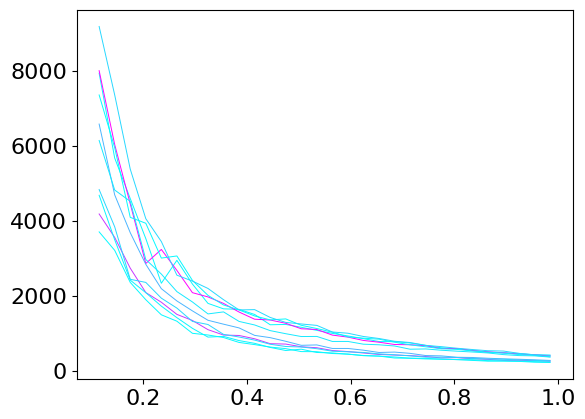

In [44]:
for i in range(n_sams):
    plt.plot(pks[i]['k'], pks[i]['pk'], lw=0.7, color=colors[i])
    
ax = plt.gca()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=locs_norm)
plt.colorbar(sm, ax=ax, label=r'$\bar{\sigma}_\text{SMF}$')
    
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$')
plt.ylabel(r'$P(k)$')

## Load bacco emu

In [74]:
emulator = baccoemu.Lbias_expansion()

  0% (0 of 12738560) |                   | Elapsed Time: 0:00:00 ETA:  --:--:--

Loading l-bias lpt emulator...


100% (12738560 of 12738560) |############| Elapsed Time: 0:00:00 Time:  0:00:00
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: Inconsi

/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when u

L-bias lpt emulator loaded in memory.
Loading smeared bao emulator...


100% (1146880 of 1146880) |##############| Elapsed Time: 0:00:00 Time:  0:00:00
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
  1% (442368 of 34867200) |              | Elapsed Time: 0:00:00 ETA:  00:00:00

Smeared bao emulator loaded in memory.
Loading non-linear l-bias emulator...


100% (34867200 of 34867200) |############| Elapsed Time: 0:00:00 Time:  0:00:00
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.23.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
 10% (122880 of 1136640) |#              | Elapsed Time: 0:00:00 ETA:  00:00:00

Nonlinear l-bias emulator loaded in memory.
Loading sigma8 emulator...


100% (1136640 of 1136640) |##############| Elapsed Time: 0:00:00 Time:  0:00:00
  3% (270336 of 6922240) |               | Elapsed Time: 0:00:00 ETA:  00:00:00

Sigma8 emulator loaded in memory.
Loading no-wiggles emulator...


100% (6922240 of 6922240) |##############| Elapsed Time: 0:00:00 Time:  0:00:00


No-wiggles emulator loaded in memory.


/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [95]:
#k = np.logspace(-1.9, np.log10(emulator.emulator['nonlinear']['k'].max()), num=100)

In [82]:
# should this match camels??
params = {
    'omega_cold'    :  Om,
    'sigma8_cold'   :  sigma8, # if A_s is not specified
    'omega_baryon'  :  Ob,
    'ns'            :  ns,
    'hubble'        :  hubble,
    'neutrino_mass' :  0.0,
    'w0'            : -1.0,
    'wa'            :  0.0,
    'expfactor'     :  1
}

In [83]:
#k, pnn = emulator.get_nonlinear_pnn(k=k, **params)

### Fit bias params

In [ ]:
def ln_like(bias_params, k_data, p_data, C_inv):
    k, p_gg, p_gm = emulator.get_galaxy_real_pk(bias=bias_params, k=k_data, **params)
    delta_y = p_gm - p_gg
    lnlk = delta_y.T * C_inv * delta_y
    return lnlk

In [ ]:
k_data = # TODO
p_data = pks[0]
C_inv = np.diag(np.ones(len(pk_data))/len(pk_data))

In [ ]:
bias_params_0 = [0.5, 0.5, 1.0, -1.0]
bias_params = scipy.optimize.minimize(ln_like, bias_params_0, args=[k_data, p_data, C_inv])